# Homework 5: Neural Networks (100 points)

In this homework, you will be implementing a fully connected neural network and a convolutional neural network using the PyTorch framework.

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the Dataset (MNIST)

We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [9]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

# Plotting Data

You must sample 10 images (one from each class) from the dataset and plot them as a grid with 2 rows of 5 columns each (i.e. of shape `2 x 5`).

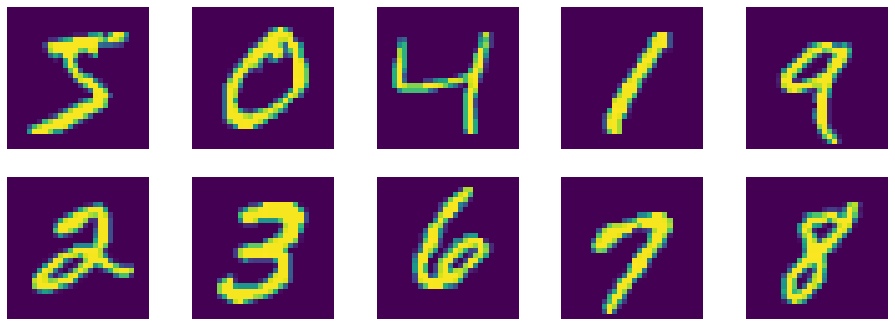

In [10]:
plt.figure(figsize=(16, 12))
used_labels = []
i=0
j=0
f=False
while f == False:
    label = train_dataset[i][1]
    if label not in used_labels:
        used_labels.append(label)
        image, _ = train_loader.dataset.__getitem__(i)
        plt.subplot(4, 5, j + 1)
        plt.axis("off")        
        plt.imshow(image.squeeze().numpy())
        i=i+1
        j=j+1
    else:
        i=i+1
    if len(used_labels) == 10:
        f=True


#### Train a Fully Connected Neural Network on MNIST

### Define the network

Build a 3-layer fully connected neural network that takes an input of size `784`, outputs `10` classes and has a hidden layer of size `(8,8)`. Use ReLU non-linearity and apply a logSoftmax function on the final layer.

The model must have the following architecture:

```
linear_layer(input_size, n_hidden)
relu
linear_layer(n_hidden, n_hidden)
relu
linear_layer(n_hidden, output_size)
log_softmax
```

In [11]:
class FCN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(input_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        pass

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        logits = self.linear3(x)
        return self.logsoftmax(logits)
        pass

### Define train and test function

Complete the function for training and evaluating the model. You must use the cross entropy loss function for training the model.

Note:
- `permute` is a function passed as an argument to train and test functions.
- `permutation_order` is a 1D torch array of size 784 (=28*28). It contains the random order for permutating the pixels in the `28x28` images.

In [12]:
def train(epoch, model, optimizer, permute_pixels=None, permutation_order=None):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data, permutation_order)
            
        optimizer.zero_grad()
        output = model(data)
        loss_func = nn.CrossEntropyLoss()
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            #loss, current = loss.item, batch * len(x)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, permute_pixels=None, permutation_order=None):

    """
    Test the model

    Args:
        model (nn.Module): model to test
        permute (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    #size = len(dataloader.dataset)
    #n_batches = len(dataloader)
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data, permutation_order)

        
        output = model(data)
        loss_func = nn.CrossEntropyLoss()
        loss = loss_func(output, target)
        test_loss += loss # sum up batch loss                                                               
        pred = np.argmax(output.detach().numpy(), axis=1)  # get the index of the max log-probability                                                                 
        correct += sum(target.numpy()==pred)

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy

# Write a function for computing the total parameter count of the model

In [13]:
# function to count number of parameters
def get_n_params(model):
    n=0
    for p in model_fcn.parameters():
        n+=np.prod(p.shape)
    return n

### Train a small fully-connected network

Optimizer : SGD with lr=0.01 and momentum=0.5

In [14]:
n_hidden = 8 # number of hidden units

model_fcn = FCN(input_size, n_hidden, output_size)
model_fcn.to(device)
optimizer = torch.optim.SGD(model_fcn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fcn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_fcn, optimizer)
    test_accuracy.append(test(model_fcn))

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.344874
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.645499
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.011392
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.698525
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.590005
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.542240
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.465466
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.370271
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.448254
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.623803

Test set: Average loss: 0.0004, Accuracy: 8708/10000 (87%)



## Train a Convolutional Neural Network (CNN) on MNIST

Define a convolutional neural network with the following architecture to classify the MNIST images.

```
Conv( 
    conv2D(input_size, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
    conv2d(conv_feature, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
)

FC(
    linear_feature(conv_feature*4*4, fc_feature),
    relu(),
    linear_feature(fc_feature, output_size),
    log_softmax()
)
```

In [15]:
class CNN(nn.Module):
    def __init__(self, input_size, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        self.hidden1 = nn.Conv2d(input_size, conv_feature, kernel_size=(5,5))
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.hidden2 = nn.Conv2d(conv_feature, conv_feature, kernel_size=5)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.hidden3 = nn.Linear(conv_feature*4*4, fc_feature)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(fc_feature, output_size)
        self.act4 = nn.LogSoftmax(dim=1)
        pass
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = self.hidden3(x)
        x = self.act3(x)

        x = self.hidden4(x)
        x = self.act4(x)
        
        return x

### Train a ConvNet with the same number of parameters

In [16]:
# Training settings 
conv_features = 6 # number of feature maps
fc_features = 50

model_cnn = CNN(1, conv_features, fc_features, output_size=10) # create CNN model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test_accuracy.append(test(model_cnn))

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305313
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.928372
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.552642
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.408070
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.554583
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.284567
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.336394
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.208960
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.346233
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.108477

Test set: Average loss: 0.0002, Accuracy: 9371/10000 (94%)



In [71]:
test_accuracy

[86.3, 94.16]

### Question: Why do you think the ConvNet performs better than the fully connected network even though both have the same number of parameters?


The ConvNet performs better because there is a strong relationship and correlation between certain data points (neighboring pixels). This is because we have image data where adjacent pixels will typically have similar colors and pixels having a certain color value will likely be clustrered together in a similar region. The ConvNet uses a filter which is basically a smaller region of the original image that goes into creating a feature map, based on data from these subregions. This helps the overall accuracy because it is able to process and analyze different things like edges, and angles which creates more relevant features for the actual image. On the other hand, the fully connected nueral network does not do all of that, rather it just looks at each point independently and does not consider any relationships between neighbors.

### What happens if the assumptions are no longer true?

In [12]:
# Given a permutation order, permute the pixels of the input image
def permute_pixels(data, permutation_order):
    """
    Permute the pixels of the input image
    
    Args:
        data (torch tensor): batch of input images of shape (B, H, W) where B is the batch size, H is the height and W is the width.
        permutation_order (1D torch array): order of the permutation
    
    Returns:
        permuted_data (torch tensor): permuted batch of input images of shape (B, 1, H, W)
    """
    
    return data.reshape(-1,28*28)[:,permutation_order].reshape(-1,1,28,28)

In [6]:
permutation_order = torch.randperm(28*28)

### ConvNet with permuted pixels

Train and evaluate a ConvNet with permuted pixels.

In [19]:
# Training settings 
conv_features = 6 # number of feature maps
fc_features = 50

model_cnn = CNN(1, conv_features, fc_features, output_size=10) # create CNN model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01,momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, permute_pixels, permutation_order)
    print()
    test(model_cnn, permute_pixels, permutation_order)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.338363
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.251196
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.148391
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.791972
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.169852
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.612046
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.851448
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.735512
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.425552
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.521650


Test set: Average loss: 0.0006, Accuracy: 8136/10000 (81%)



### Fully-Connected with Permuted Pixels

Train and evaluate a fully connected network with permuted pixels.

In [20]:
n_hidden = 8    # number of hidden units

model_fnn = FCN(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = torch.optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, permute_pixels)
    test(model_fnn, permute_pixels)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.329360
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.475784
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.937501
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.636677
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.651288
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.589767
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.489365
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.333443
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.298442
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.294525

Test set: Average loss: 0.0004, Accuracy: 8819/10000 (88%)



### Question: We observe that the ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same. Provide an explanation for this.

The main reason for this is that the pixels are now out of order (as shown in the image below) which nullifies the correlation between neighboring pixels. This hurts the ConvNet's performance because it has the capability to take advantage of this correlation as it utilizes filters and creates a feature map. After the pixels are scattered, there are no similarities in color bewteen adjacent pixels so there is no real advatange to using these filters because the pixels in each region are completley randomized. The Fully-Connected Network is unaffected by this because it just looks at each pixel individually anyway, so relationships between neighbors are not taken into account. It can perfrom just as well when the pixels are out of order because the overall process is still the same. This is shown by the fact that the accuracy dropped from 94% to 81% for the ConvNet while the accuracy stayed basically the same for the Fully-Connected Network.

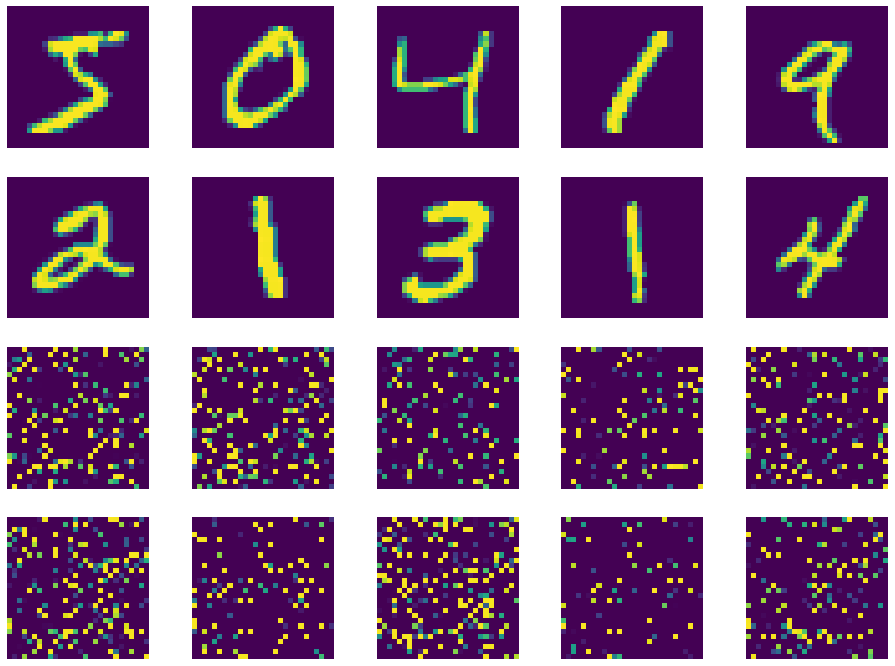

In [15]:
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = permute_pixels(image.clone(), permutation_order)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')